In [28]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics.functional as metrics


from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, VGG16_Weights
from sklearn.model_selection import train_test_split
from typing import List, Dict, Union


from torchinfo import summary


In [29]:
class Custom_VGG(nn.Module):
    def __init__(
        self,
        features: nn.Module,
        nclasses: int = 3,
        init_weights: bool = True,
        dropout: float = 0.5,
    ) -> None:
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, nclasses),
        )
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(
                        m.weight, mode="fan_out", nonlinearity="relu"
                    )
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [30]:
# fmt: off
cfgs: Dict[str, List[Union[str, int]]] = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}
# fmt: on


In [31]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = int(v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [32]:
def make_weights(labels: pd.DataFrame, nclasses: int):
    labels = labels.values
    weight_list = []

    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1 / count
        weights = [weight] * count
        weight_list += weights

    return weight_list


In [33]:
preprocessing = transforms.Compose(
    [
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


In [34]:
file_root = "../DATA"
dogDS = ImageFolder(root=file_root, transform=preprocessing)

print(dogDS.classes, len(dogDS.targets), len(dogDS.imgs), sep="\n")


['BIG', 'MID', 'SMALL']
20283
20283


In [35]:
imgDF = pd.DataFrame(dogDS.imgs, columns=["image", "label"])
imageDF = imgDF[["image"]]
labelSR = imgDF.label


In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(
    imageDF, labelSR, test_size=0.1, random_state=42, stratify=labelSR
)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, sep="\n")


(18254, 1)
(2029, 1)
(18254,)
(2029,)


In [37]:
train_idx = X_train.index.to_list()
valid_idx = X_valid.index.to_list()


In [38]:
trainDS = Subset(dogDS, train_idx)
validDS = Subset(dogDS, valid_idx)

len(trainDS.dataset.targets), len(validDS.dataset.targets)


(20283, 20283)

In [39]:
train_weights = make_weights(y_train, len(y_train.unique()))
train_weights = torch.DoubleTensor(train_weights)
valid_weights = make_weights(y_valid, len(y_valid.unique()))
valid_weights = torch.DoubleTensor(valid_weights)

train_weights.shape, valid_weights.shape


(torch.Size([18254]), torch.Size([2029]))

In [40]:
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
valid_sampler = WeightedRandomSampler(valid_weights, len(valid_weights))


In [41]:
batch_size = 64

trainDL = DataLoader(
    trainDS, batch_size=batch_size, sampler=train_sampler, drop_last=True
)
validDL = DataLoader(
    validDS, batch_size=batch_size, sampler=valid_sampler, drop_last=True
)


In [42]:
for image, label in trainDL:
    print(image.shape, label.shape)
    break


torch.Size([64, 3, 224, 224]) torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

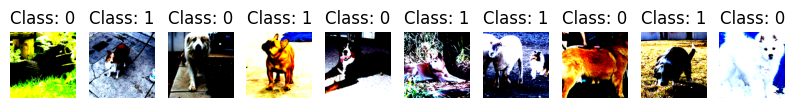

In [43]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.transpose(image[i], (1, 2, 0)))
    plt.title("Class: " + str(label[i].item()))
plt.show()


In [44]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE :", DEVICE)


DEVICE : cpu


In [45]:
OUT = len(trainDS.dataset.classes)
MODEL = Custom_VGG(
    features=make_layers(cfgs["VGG11"], batch_norm=True), nclasses=OUT
).to(DEVICE)
OPTIMIZER = optim.Adam(MODEL.parameters())
LOSS_FN = nn.CrossEntropyLoss()


In [46]:
summary(MODEL, input_size=(64, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
Custom_VGG                               [64, 3]                   --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 224, 224]        128
│    └─ReLU: 2-3                         [64, 64, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 64, 112, 112]        --
│    └─Conv2d: 2-5                       [64, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-6                  [64, 128, 112, 112]       256
│    └─ReLU: 2-7                         [64, 128, 112, 112]       --
│    └─MaxPool2d: 2-8                    [64, 128, 56, 56]         --
│    └─Conv2d: 2-9                       [64, 256, 56, 56]         295,168
│    └─BatchNorm2d: 2-10                 [64, 256, 56, 56]         512
│    └─ReLU: 2-11                        [64, 256, 56, 56]         --


In [47]:
def learning(epoch, model, loader, optimizer, mode="train", log_interval=100):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "test":
        model.eval()
        is_train = False
    else:
        raise ValueError("Invalid mode:", mode)

    loss_value = 0
    correct = 0
    with torch.set_grad_enabled(is_train):
        for batch_idx, (image, label) in enumerate(loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            loss = LOSS_FN(output, label)
            loss_value += loss.item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if batch_idx % log_interval == 0:
                    print(
                        f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}"
                    )

    loss_value /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    return loss_value, accuracy


In [21]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):

    learning(epoch, MODEL, trainDL, OPTIMIZER, mode="train", log_interval=1)
    test_loss, test_accuracy = learning(epoch, MODEL, validDL, OPTIMIZER, mode="test")

    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )


Train Epoch: 1 [0]	Train Loss: 1.172435
Train Epoch: 1 [1]	Train Loss: 136.334076
Train Epoch: 1 [2]	Train Loss: 47.040611
Train Epoch: 1 [3]	Train Loss: 18.247011
Train Epoch: 1 [4]	Train Loss: 4.480062
Train Epoch: 1 [5]	Train Loss: 2.303841
Train Epoch: 1 [6]	Train Loss: 2.391645
Train Epoch: 1 [7]	Train Loss: 2.960186


KeyboardInterrupt: 

In [56]:
vgg_sequential = nn.Sequential(
    nn.Linear(512 * 7 * 7, 2048),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(2048, out_features=256),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(256, 3),
)


In [57]:
vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)

vgg_model.classifier = vgg_sequential


In [58]:
summary(model=vgg_model, input_size=(64, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 3]                   --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [64, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [64, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [64, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [64, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [64, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [64, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [64, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [64, 256, 56, 56]         29

In [59]:
for name, param in vgg_model.named_parameters():
    param.requires_grad = False

for name, param in vgg_model.classifier.named_parameters():
    param.requires_grad = True


In [60]:
EPOCHS = 5

for epoch in range(1, EPOCHS + 1):

    learning(epoch, vgg_model, trainDL, OPTIMIZER, mode="train", log_interval=10)
    test_loss, test_accuracy = learning(
        epoch, vgg_model, validDL, OPTIMIZER, mode="test"
    )

    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )


Train Epoch: 1 [0]	Train Loss: 1.090413
Train Epoch: 1 [10]	Train Loss: 1.162801
Train Epoch: 1 [20]	Train Loss: 1.118097
Train Epoch: 1 [30]	Train Loss: 1.120042
Train Epoch: 1 [40]	Train Loss: 1.112801
Train Epoch: 1 [50]	Train Loss: 1.121345
Train Epoch: 1 [60]	Train Loss: 1.151065
Train Epoch: 1 [70]	Train Loss: 1.134523
